In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from research.pipes.sql import SQLPipe
from research.utils import test_trading_liquidity

pd.options.display.float_format = '{:,.4f}'.format

load_dotenv()

USER = os.getenv('PSQL_USERNAME')
PASS = os.getenv('PSQL_PASSWORD')
DATABASE = 'crypto'
SCHEMA = 'bihourly'
INTERVAL = '30T'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, INTERVAL)

In [27]:
# This will take a bit to run
vol = test_trading_liquidity(interval='1hour')

In [30]:
data = pd.read_csv("data/TTM30T.csv", index_col=0)

low_vol = vol[vol < 25_000].index.to_list()
low_vol = [symbol.lower().replace("-","") for symbol in low_vol]

data = data[data["pvalue"] < 0.01]
data = data[data["hurst"] < 0.50]
data = data[~data['x'].isin(low_vol) & ~data['y'].isin(low_vol)]
excluded_values = []
data = data[~data['x'].isin(excluded_values) & ~data['y'].isin(excluded_values)]

data = data.sort_values('halflife').reset_index(drop=True)

data.head()

,x,y,tscore,pvalue,hurst,halflife
0,vrausdt,xprusdt,-8.0909,0.0000,0.3815,72.8196
1,kdausdt,waxusdt,-6.3555,0.0000,0.4758,115.2951
2,dotusdt,xprusdt,-6.2510,0.0000,0.4049,118.8329
3,vrausdt,dotusdt,-6.3287,0.0000,0.3952,126.7005
4,vrausdt,kdausdt,-8.0636,0.0000,0.4643,127.4905


In [39]:
i = 3
x = data.loc[i, "x"]
y = data.loc[i, "y"]
df = pipe.query_pairs_trading_backtest([x, y])
print(x,y)

vrausdt dotusdt


In [40]:
closes = np.log(df.xs(
    "close", level=1, axis=1
).rename(columns={0: x, 1: y}))

(17520,)


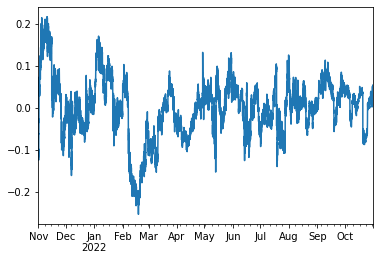

In [41]:
slicer = -17520

res = sm.OLS(
    endog=closes.iloc[slicer:, 1],
    exog=sm.add_constant(closes.iloc[slicer:, 0]),
).fit()

res.resid.plot()
print(res.resid.shape)

In [42]:
def engle_granger(resids, level="1%", maxlag=1):
    test_results = adfuller(resids, maxlag=maxlag, regression="n")

    interpretation = test_results[0] < test_results[4][level]

    print("-------- Results ---------")
    print(f"Stationary at {level} confidence? {interpretation}")
    print(f"Critical value: {test_results[4][level]:.4f}")
    print(f"t-score for test: {test_results[0]:.4f}")
    print(f"p-score for test: {test_results[1]:.4f}")

engle_granger(res.resid)

-------- Results ---------
Stationary at 1% confidence? True
Critical value: -2.5659
t-score for test: -6.3024
p-score for test: 0.0000
